# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Alessandro Cesa

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
#Run if you don't already have the dataset
%%capture
!wget -c https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/archive/main/CVPR2023_project_2_and_3_data.zip
!unzip CVPR2023_project_2_and_3_data.zip

In [3]:
#Adjust according to your path
import sys
sys.path.append('/content/Computer_Vision_Project_Cesa-main/')

from image_handling_functions import *
from train_test_functions import *
from neural_networks import *

In [4]:
#Adjust according to your path
train_path = "/content/Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/train"
test_path = "/content/Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/test"

In [5]:
device = get_default_device()

In [6]:
train=ImageFolder(root=train_path,transform=resize_transformation)
test=ImageFolder(root=test_path,transform=resize_transformation)

In [7]:
%%capture
"""
# check the dataset size
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(train.classes)
"""

label: 0
class: Bedroom


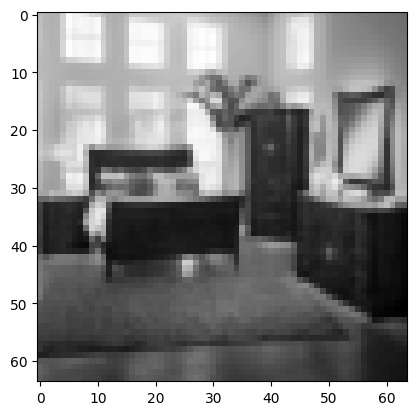

In [8]:

# get image no. 1 and its label
index=1
img,label=train[index]

print(f"label: {label}")

print("class: " + train.classes[label])
# display
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)


In [7]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [8]:
#split training set into training and validation
train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

In [11]:
# Create data loaders.
# Data loaders are basically objects that make easy to iterate through the data by batches of some batch_size
batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False,pin_memory=True)

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [13]:
%%capture
"""
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
"""

In [14]:
%%capture
"""
classes=train.classes

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

img=torchvision.utils.make_grid(images)
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)).astype(np.uint8),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
"""

In [15]:
# Instantiate the model
model = simpleCNN()
model.to(device)
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# Print the model summary
#print(model)

EPOCH1:
LOSS train: 2.7080280065536497 validation: 2.707507610321045 | validation_accuracy: 6.666666666666667% 
EPOCH2:
LOSS train: 2.7064559876918795 validation: 2.705883026123047 | validation_accuracy: 5.777777777777778% 
EPOCH3:
LOSS train: 2.700666534900665 validation: 2.6924655437469482 | validation_accuracy: 7.555555555555555% 
EPOCH4:
LOSS train: 2.6834333658218386 validation: 2.641897201538086 | validation_accuracy: 12.0% 
EPOCH5:
LOSS train: 2.651807487010956 validation: 2.6364219188690186 | validation_accuracy: 10.222222222222221% 
EPOCH6:
LOSS train: 2.5934670209884643 validation: 2.491793632507324 | validation_accuracy: 15.555555555555555% 
EPOCH7:
LOSS train: 2.58232986330986 validation: 2.550381660461426 | validation_accuracy: 14.222222222222221% 
EPOCH8:
LOSS train: 2.496866595745087 validation: 2.5013370513916016 | validation_accuracy: 14.222222222222221% 
EPOCH9:
LOSS train: 2.4514476001262664 validation: 2.4652066230773926 | validation_accuracy: 16.0% 
EPOCH10:
LOSS t

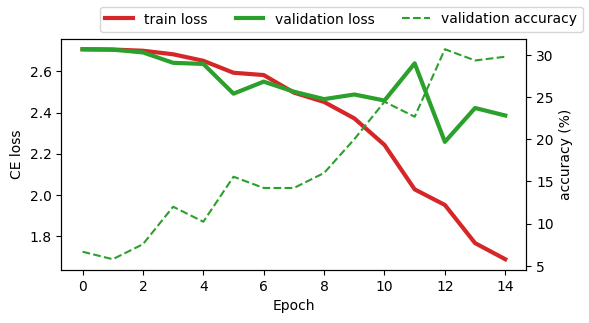

In [16]:
model_path=train_model(model,train_loader,validation_loader,loss_function,optimizer,15,device)

Accuracy of the network on the test images: 26.934673366834172%


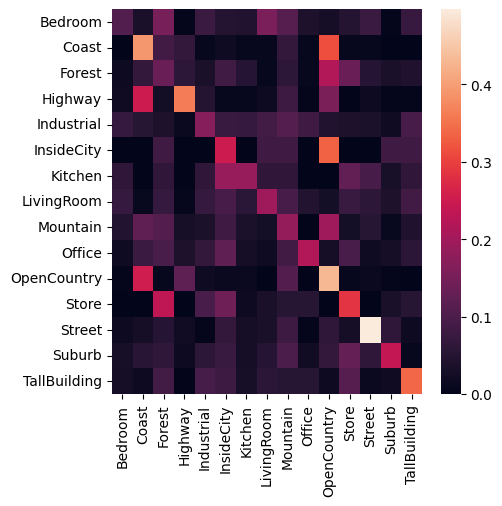

In [17]:
test_model(simpleCNN(),model_path,test_loader,test,device)

In [18]:
!rm model*

In [19]:
def resize_reflect_transformation(img):
  resize = transforms.Compose([transforms.Resize([64,64]),transforms.RandomHorizontalFlip(1),
  transforms.ToTensor(),transforms.Grayscale()])
  i = resize(img)
  i =i*255.0 #back to 0-255
  return i

In [38]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [39]:
training_set_reflected=ImageFolder(root=train_path,transform=resize_reflect_transformation)

In [40]:
train_loader_augmented=DataLoader(
    ConcatDataset([training_set,training_set_reflected]),
     batch_size=batch_size,shuffle=True,pin_memory=True)

In [41]:
train_loader_augmented=DeviceDataLoader(train_loader_augmented,device)

In [ ]:
model = simpleCNN()
model.to(device)
model.apply(init_weights)

In [ ]:
model_path=train_model(model,train_loader_augmented,validation_loader,loss_function,optimizer,15,device)

Accuracy of the network on the test images: 5.125628140703518%


/content/Computer_Vision_Project_Cesa-main/train_test_functions.py:135: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],


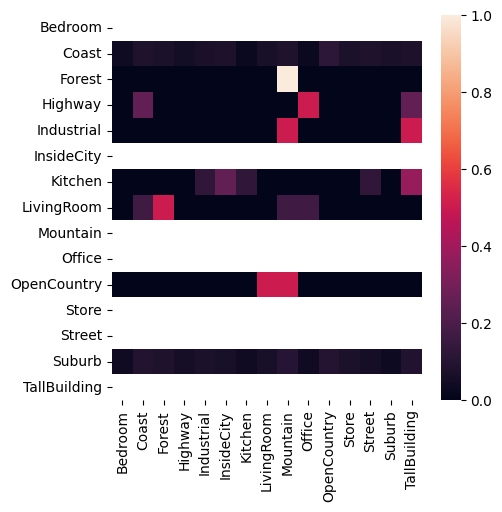

In [25]:
test_model(simpleCNN(),model_path,test_loader,test,device)

In [26]:
!rm model*